In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.ticker as ticker


import Window_Function
import window_function_2
import HERA_hack_FG
import pspec
import make_universe

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=11
plt.rcParams['xtick.labelsize']=11



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
pbeam = True 
norm = True 


npix_row,npix_col = 60,60

npix_tot = npix_row * npix_col

Ly = 2000
Lx = 2000

nbins = 40


In [168]:
################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[0,-57.39295490174667],[30,0],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]


#dishes = np.array([[0,0],[33.33,0],[0,70.71],[33.33, 70.71]])
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=0.1, Tsys=300, beam_width=2, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 1, freq = 150, delta_t = 0.01 ,corners = acorner, beam_sigma_cutoff=2.5, sky_shape = (npix_row,npix_col), norm = norm, pbeam = pbeam)

obs.compute_M(None,None)

############# DEFINE FAKE UNIVERSE SPEC #########


def ps(x):
    mu, sigma = 0.027348316,0.004
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))
#     return np.sin(100*x)

make_uni = make_universe.universe(ps,obs.sky_shape[0],obs.sky_shape[1],Ly,Lx, mean = None) #100 Mpc by 100Mpc




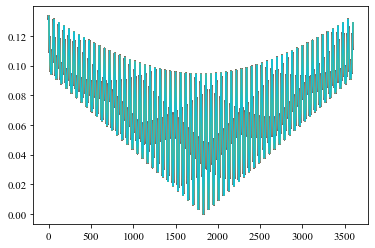

In [293]:
nreals = 100

ave_Cij = np.zeros((npix_tot,npix_tot))
ck_ave = np.zeros((npix_tot,npix_tot), dtype = complex)
cov_spec = np.zeros(npix_tot,dtype = complex)
obs_spec = np.zeros(nbins-1)
k_hera = []


for i in range(nreals): 
    
    universe, universe_stdev = make_uni.make_2D_universe()
    
    power_spec_stdev = pspec.Power_Spectrum(universe_stdev,Ly,Lx,nbins,False) #100 Mpc by 100M
    power_spec_stdev.cosmo_FFT2()

   
    spec_cov = np.reshape(power_spec_stdev.ps_data, (3600,))
    cov_spec += spec_cov #find the average spec

   
    
    fft_uni = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(universe_stdev))), (npix_tot,))
    ck = np.outer(fft_uni,np.conj(fft_uni).T)
    ck_ave += ck
    

    stacked_sky = np.hstack(universe_stdev)
    sky = np.real(obs.convolve_map(stacked_sky,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)) # do not include .T here for window functioning! (I think)
    
    
    fft_sky = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(square_sky))), (npix_tot,))
    power_spec_obs = pspec.Power_Spectrum(square_sky.T,Ly,Lx,nbins,False) #100 Mpc by 100M
    pk_hera = power_spec_obs.compute_2D_pspec()
    obs_spec += pk_hera[1]
    
    if i == 0:#make sure to save the ks!
        k_hera = pk_hera[0]
    else:
        pass

    C_ij_obs = np.real(np.outer(fft_sky,(np.conj(fft_sky).T)))
    ave_Cij += C_ij_obs 


ave_Cij /= nreals
ave_Cij = np.diag(ave_Cij)
ck_ave_diag = np.diag(ck_ave)
ck_ave_diag = np.real(ck_ave_diag)/nreals
cov_spec /= nreals
obs_spec /= nreals

/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


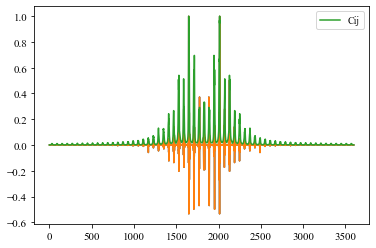

In [295]:
plt.plot(np.dot(window.window,ck_ave_diag)/max(np.dot(window.window,ck_ave_diag)))
plt.plot(np.dot(window.window,cov_spec)/max(np.dot(window.window,cov_spec)))
plt.plot(ave_Cij/max(ave_Cij), label = 'Cij')
plt.legend()

In [296]:
indices = np.argsort(window.k) #find the indices that sort self.

cii_sorted = np.take(np.diag(ave_cov_obs),indices)#axis 1 sorts the columns into the right order
cii_sorted = np.asarray(cii_sorted)#why is this transpose here??? I think because of reshaping but check

hist, bin_edges = np.histogram(window.k_sorted, bins = nbins)
cii_sorted_binned = np.zeros(nbins)

min_index = 0
for i in range(len(bin_edges)-1): #pick a bin!
    max_index = np.sum(hist[:i+1])#hist[i] + min_index 
    min_index = np.sum(hist[:i])
    a = np.sum(cii_sorted[min_index:max_index]) #for row j, sum the columns from min to max index of the bin
    c = hist[i] #number of P_k values in that bin 
    cii_sorted_binned[i] = a/c #compute average W that bin


In [297]:
window = window_function_2.Window_Function(obs.Mmat,obs.sky_shape[0],obs.sky_shape[1],Lx,Ly,150,nbins)

window_cov_spec = window.compute_pspec_estimate(cov_spec) #lines 3 an 4 should be exactly the same 
ps_spec_ave = window.compute_pspec_estimate(cov_spec/(33.333*33.333)**2)
ps_spec_theory  =  window.compute_pspec_estimate(ps)

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  self.pk_window_binned[i] = a/c #compute average W that bin


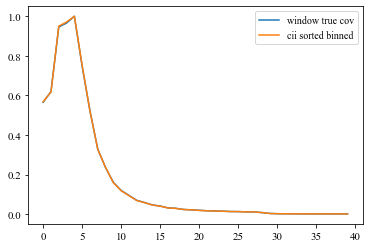

In [300]:
plt.plot(window_cov_spec[1]/max(window_cov_spec[1]), label = 'window true cov')
# plt.plot(obs_spec/max(obs_spec), label = 'observed field spec')
plt.plot(cii_sorted_binned/max(cii_sorted_binned), label = 'cii sorted binned')
plt.legend()

In [274]:
print(window.delta_phi,window.delta_theta)
print(Lx/npix_row)

27.534821641037112 27.534821641032977
33.333333333333336


In [306]:
window.normalize_window()

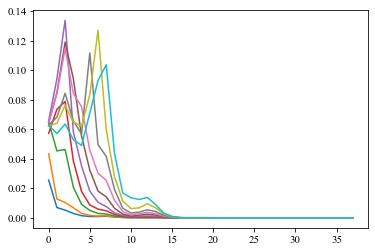

In [310]:

for i in range(10):
    plt.plot(window.window_norm[i,2:])